#  Yellow Canary vs. Apple Green: Wrangling NYC Taxi Trip Data

In this competition, the challenge is to build a model that predicts the total ride duration of taxi trips in New York City. The primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables. This notebook is consists of the following sections:

1. Data Loading & Basic Consistency Check
2. Visualizing Features
3. Feature Engineerings
    1. Trip Distance
    2. Trip Average speed
    3. Airport Pickup/Dropoff
    4. Pickup/Drop-off Cluster
4. Data Cleaning

Next step is to update with the notebook with external data and modeling.

## 1. Data Loading & Basic Check
Data and required library will be loaded and the basic checking such as consistency check would be perform. Columns would be transformed to appropriate data types and further features extractions would be carried out. 

In [1]:
# Loading necessary library for analysis
%matplotlib inline
import numpy as np 
import pandas as pd 
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')

plt.rcParams['axes.facecolor']='#f4f5f7'

/Users/hooi-yeam/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Loading competition data files
np.random.seed(42)
t0 = dt.datetime.now()
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(3)
memory usage: 122.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 625134 entries, id3004672 to id0621643
Data columns (total 8 columns):
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_lon

In [4]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [5]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


In [6]:
print(train.store_and_fwd_flag.unique())
print(test.vendor_id.unique())

['N' 'Y']
[1 2]


As expected from descriptions, data loaded consists of columns corresponding to each trip with a unique identifier <b>Id</b> for each records. Each records consists of vendor_id, pickup_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude,dropoff_latitude and store_and_fwd_flag. In train dataset, additional columns of dropoff_datetime and trip_duration is also available.

There's no null values inside the dataset - no additional imputation needed and both store_and_fwd_flag and vendor_id is consistent with the data description.

Basic statistic and distribution for both dataset are fairly similar.

## 2. Visualizing Feature
Date information would be converted to appropriate data type and additional datetime information would be extracted for EDA. The following section will refrain from examining test dataset too closely.

In [7]:
# Converting datetime format
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [8]:
# Extracting datetime information into new columns
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['pickup_day_of_month'] = train['pickup_datetime'].dt.day
train['pickup_week_of_month'] = train['pickup_datetime'].dt.weekofyear
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_week_hour'] = train['pickup_day_of_week'] * 24 + train['pickup_hour']

train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day_of_week'] = train['dropoff_datetime'].dt.dayofweek
train['dropoff_day_of_month'] = train['dropoff_datetime'].dt.day
train['dropoff_week_of_month'] = train['dropoff_datetime'].dt.weekofyear
train['dropoff_month'] = train['dropoff_datetime'].dt.month
train['dropoff_hour'] = train['dropoff_datetime'].dt.hour
train['dropoff_week_hour'] = train['dropoff_day_of_week'] * 24 + train['dropoff_hour']

test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day_of_week'] = test['pickup_datetime'].dt.dayofweek
test['pickup_day_of_month'] = test['pickup_datetime'].dt.day
test['pickup_week_of_month'] = test['pickup_datetime'].dt.weekofyear
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_week_hour'] = test['pickup_day_of_week'] * 24 + test['pickup_hour']

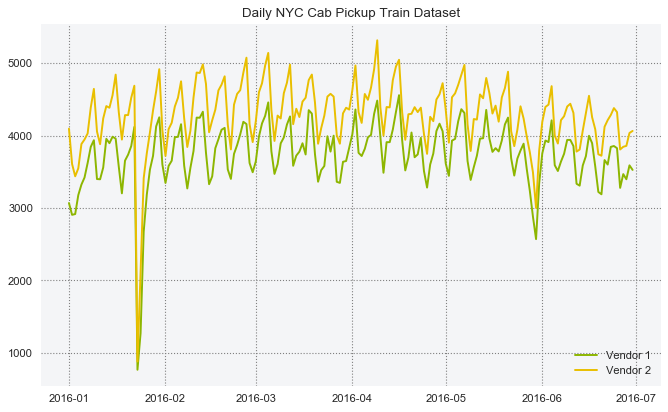

In [9]:
plt.clf()
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
x = train['pickup_date'].unique()
x.sort()

plt.plot_date(x, train[train['vendor_id']==1].groupby('pickup_date').size(), '#8db600')
plt.plot_date(x, train[train['vendor_id']==2].groupby('pickup_date').size(), '#E9BF00')
plt.title("Daily NYC Cab Pickup Train Dataset")
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.legend(['Vendor 1', 'Vendor 2'], loc='lower right')
plt.show()

Two major drop of demands in pickup is observed in January and May. 

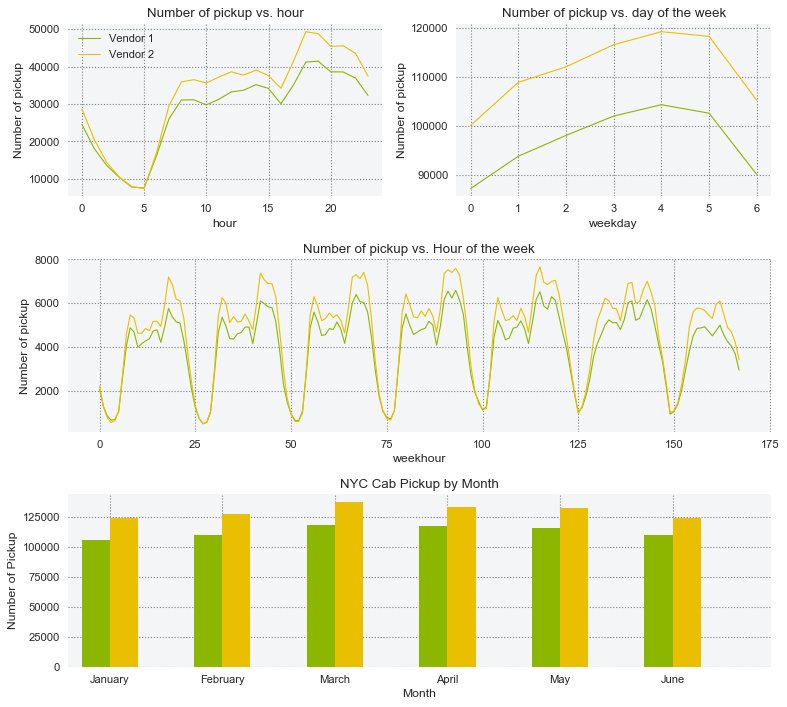

In [10]:
plt.clf()
plt.figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0, :1])
ax2 = plt.subplot(gs[0, 1:2])
ax3 = plt.subplot(gs[1,:])
ax5 = plt.subplot(gs[2,:])

ax1.plot(train[train['vendor_id']==1].groupby('pickup_hour').size(), '#8DB600', lw=1, ls ='-')
ax1.plot(train[train['vendor_id']==2].groupby('pickup_hour').size(), '#E9BF00', lw=1,  ls ='-')
ax1.grid(color='grey', linestyle=':', linewidth=1)
ax1.set_xlabel('hour')
ax1.set_ylabel('Number of pickup')
ax1.set_title('Number of pickup vs. hour')

ax2.plot(train[train['vendor_id']==1].groupby('pickup_day_of_week').size(), '#8DB600', lw=1, ls ='-')
ax2.plot(train[train['vendor_id']==2].groupby('pickup_day_of_week').size(), '#E9BF00', lw=1,  ls ='-')
ax2.grid(color='grey', linestyle=':', linewidth=1)
ax2.set_xlabel('weekday')
ax2.set_ylabel('Number of pickup')
ax2.set_title('Number of pickup vs. day of the week')

ax3.plot(train[train['vendor_id']==1].groupby('pickup_week_hour').size(), '#8DB600', lw=1, ls ='-')
ax3.plot(train[train['vendor_id']==2].groupby('pickup_week_hour').size(), '#E9BF00', lw=1,  ls ='-')
ax3.grid(color='grey', linestyle=':', linewidth=1)
ax3.set_xlabel('weekhour')
ax3.set_ylabel('Number of pickup')
ax3.set_title('Number of pickup vs. Hour of the week')

month_v1 = train[train['vendor_id']==1].groupby('pickup_month').size().rename('id').reset_index()
month_v2 = train[train['vendor_id']==2].groupby('pickup_month').size().rename('id').reset_index()
pos = list(range(len(month_v1['id'])))
width = 0.25

# fig1, ax1 = plt.subplots(figsize=(10,5))
ax5.bar(pos,month_v1['id'], width, color='#8DB600',label=month_v1['pickup_month'][0])
ax5.bar([p + width for p in pos],month_v2['id'], width,color='#E9BF00',label=month_v2['pickup_month'][0])
ax5.set_title("NYC Cab Pickup by Month")
ax5.set_ylabel("Number of Pickup")
ax5.grid(color='grey', linestyle=':', linewidth=1)

# Set the position of the x ticks
ax5.set_xticks([p + 0.5 *width for p in pos])

# Set the labels for the x ticks
ax5.set_xticklabels(['January','February', 'March', 'April', 'May','June'])

# Setting the x-axis and y-axis limits
ax5.set_xlim(min(pos)-width, max(pos)+width*4)
ax5.set_xlabel('Month')

ax1.legend(['Vendor 1', 'Vendor 2'], loc='upper left')
plt.tight_layout()
plt.show()

del(month_v1, month_v2)

1. Hourly, the demand of pickup is at 5am and steadily increasing throughout the day before descending at 6pm. Minor drop of pickup at 4pm.
2. Weekly, the pickup is steadily increase from Monday to Friday. Lower pickup observed on weekends.
3. Vendor 2 has more pickup in general compared to vendor 1

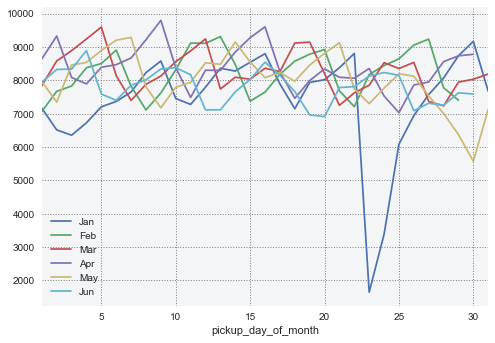

In [11]:
df = train.groupby(['pickup_month','pickup_day_of_month']).size().rename('pickup').reset_index()
plt.clf()
fig, ax = plt.subplots()
labels = []
for key, grp in df.groupby(['pickup_month']):
    ax = grp.plot(ax=ax, kind='line', x='pickup_day_of_month', y='pickup')
    labels.append(key)
ax.legend(['Jan','Feb','Mar','Apr','May','Jun'], loc='best')
ax.grid(color='gray', linestyle=':', linewidth=1)
plt.show()

del(df)

No discernable pattern of the pickup based on days

In [12]:
# Creating dataset for comparison of store & forward flag
fwd_flag_v1 = train[train['vendor_id']==1].groupby('store_and_fwd_flag').size().rename('v1').reset_index()
fwd_flag_v2 = train[train['vendor_id']==2].groupby('store_and_fwd_flag').size().rename('v2').reset_index()
fwd_flag_ls = fwd_flag_v1.merge(fwd_flag_v2, how='left', left_on='store_and_fwd_flag',right_on='store_and_fwd_flag')
fwd_flag_ls = fwd_flag_ls.fillna(0)

psg_count_v1 = train[train['vendor_id']==1].groupby('passenger_count').size().rename('v1').reset_index()
psg_count_v2 = train[train['vendor_id']==2].groupby('passenger_count').size().rename('v2').reset_index()
psg_count_ls = psg_count_v1.merge(psg_count_v2, how='outer', left_on='passenger_count',right_on='passenger_count')
psg_count_ls = psg_count_ls.fillna(0)

del(fwd_flag_v1,fwd_flag_v2,psg_count_v1,psg_count_v2)

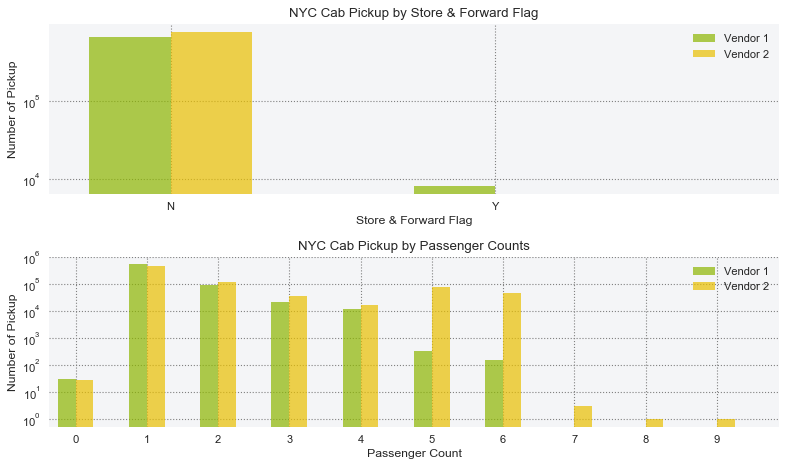

In [13]:
width = 0.25

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
# Number of pessanger
pos1 = list(range(len(fwd_flag_ls['store_and_fwd_flag'])))

#fig3, ax3 = plt.subplots(figsize=(10,5))
ax1.bar(pos1,fwd_flag_ls['v1'], width, color='#8DB600',alpha=0.7,label=fwd_flag_ls['store_and_fwd_flag'][0])
ax1.bar([p + width for p in pos1],fwd_flag_ls['v2'],  width,color='#E9BF00',alpha=0.7,label=fwd_flag_ls['store_and_fwd_flag'][0])
ax1.set_title("NYC Cab Pickup by Store & Forward Flag")
ax1.set_ylabel("Number of Pickup")

# Set the position of the x ticks
ax1.set_xticks([p + 0.5 *width for p in pos1])

# Set the labels for the x ticks
ax1.set_xticklabels(fwd_flag_ls['store_and_fwd_flag'])
ax1.set_xlabel('Store & Forward Flag')

# Setting the x-axis and y-axis limits
ax1.set_xlim(min(pos1)-width, max(pos1)+width*4)
#ax3.set_ylim([0, max(psg_count_ls['train'] + psg_count_ls['test'])])
ax1.set_yscale("log")
ax1.grid(color='grey', linestyle=':', linewidth=1)

# Number of pessanger
pos2 = list(range(len(psg_count_ls['passenger_count'])))

#fig3, ax3 = plt.subplots(figsize=(10,5))
ax2.bar(pos2,psg_count_ls['v1'], width,color='#8DB600', alpha=0.7,label=psg_count_ls['passenger_count'][0])
ax2.bar([p + width for p in pos2],psg_count_ls['v2'], width,alpha=0.7,color='#E9BF00',label=psg_count_ls['passenger_count'][0])
ax2.set_title("NYC Cab Pickup by Passenger Counts")
ax2.set_ylabel("Number of Pickup")

# Set the position of the x ticks
ax2.set_xticks([p + 0.5 *width for p in pos2])

# Set the labels for the x ticks
ax2.set_xticklabels(psg_count_ls['passenger_count'])
ax2.set_xlabel('Passenger Count')

# Setting the x-axis and y-axis limits
ax2.set_xlim(min(pos2)-width, max(pos2)+width*4)
#ax3.set_ylim([0, max(psg_count_ls['train'] + psg_count_ls['test'])])
ax2.set_yscale("log")
ax2.grid(color='grey', linestyle=':', linewidth=1)

# Adding the legend and showing the plot
ax1.legend(['Vendor 1', 'Vendor 2'], loc='upper right')
ax2.legend(['Vendor 1', 'Vendor 2'], loc='upper right')
plt.tight_layout()
plt.show()

del(psg_count_ls,fwd_flag_ls)


1. Most pickup has no issues requiring it to store and forward trip information - only vendor 1 required some of the trip information to be stored and send later to server
2. Most pickup has minimum one passenger - some trips were recorded for empty cab
3. Only vendor 2 has passenger count > 6 (potentially constraints by vehicle?)

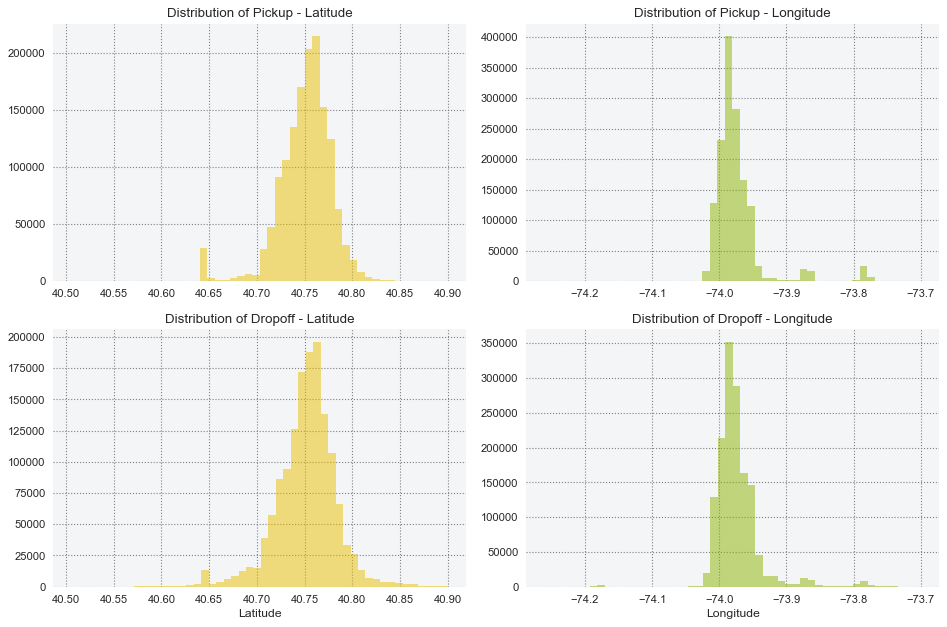

In [14]:
NYState_latitude = [40.49444, 45.01167]
NYState_longitude = [-71.79028, -79.765]
NJ_latitude = [38.91667, 41.35639]
NJ_longitude = [-73.89417, -75.58333]
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot(221)
plt.hist(train[(train['pickup_latitude']>40.5) & (train['pickup_latitude']<40.9)]\
         ['pickup_latitude'], bins=50,alpha=0.5,color='#E9BF00')
plt.title('Distribution of Pickup - Latitude')
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.legend(loc='best')

ax2 = plt.subplot(223, sharex=ax1)
plt.hist(train[(train['dropoff_latitude']>40.5) & (train['dropoff_latitude']<40.9)]\
         ['dropoff_latitude'], bins=50,alpha=0.5,color='#E9BF00')
plt.title('Distribution of Dropoff - Latitude')
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.xlabel('Latitude')
plt.legend(loc='best')

ax3 = plt.subplot(222)
plt.hist(train[(train['pickup_longitude']>-74.26) & (train['pickup_longitude']<-73.7)]\
         ['pickup_longitude'], bins=50,alpha=0.5,color='#8DB600')
plt.title('Distribution of Pickup - Longitude')
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.xlim([-74.05, -73.7])
plt.legend(loc='best')
#plt.gca().set_yscale("log")

ax4 = plt.subplot(224, sharex=ax3)
plt.hist(train[(train['dropoff_longitude']>-74.26) & (train['dropoff_longitude']<-73.7)]\
         ['dropoff_longitude'], bins=50,alpha=0.5,color='#8DB600')
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.title('Distribution of Dropoff - Longitude')
plt.xlabel('Longitude')
#plt.xlim([-74.05, -73.7])
#plt.gca().set_yscale("log")

plt.tight_layout()
plt.show()

The latitude and longitude distribution is limited by NYC border and we're seeing pickup concentrated approximately at (40.77,-73.75) - at Manhattan borough. Most extreme and out of state trip information would be discussed more in data cleaning.

### 2.1. Trip duration features and its interaction
The following section will examines trip duration feature and its interaction to other features.

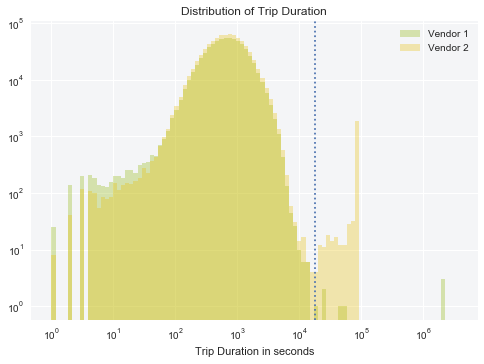

In [15]:
min_trip_duration = train['trip_duration'].min()
max_trip_duration = train['trip_duration'].max()

bins = 10 ** np.linspace(np.log10(min_trip_duration), np.log10(max_trip_duration), 100)
plt.hist(train[train['vendor_id']==1]['trip_duration'], bins=bins, alpha=0.3,color='#8DB600', label='Vendor 1')
plt.hist(train[train['vendor_id']==2]['trip_duration'], bins=bins, alpha=0.3,color='#E9BF00', label='Vendor 2')
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration in seconds')
plt.ylabel('Number of Pickup')
plt.legend(loc='upper right')
plt.axvline(18000, ls=':')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.show()


Majority of rides for both vendor are approximately normal distributed in log-log scale. Few aberrations to this pattern observed are:

1. Both vendor have extremely short trip with duration less than 10secs.
2. An additional peak close to 24hrs for vendor 2. (Note that of none of trip information with store_and_fwd_flag = Y for vendor 2)
3. Only vendor 1 has long trips with duration exceeed 1 days

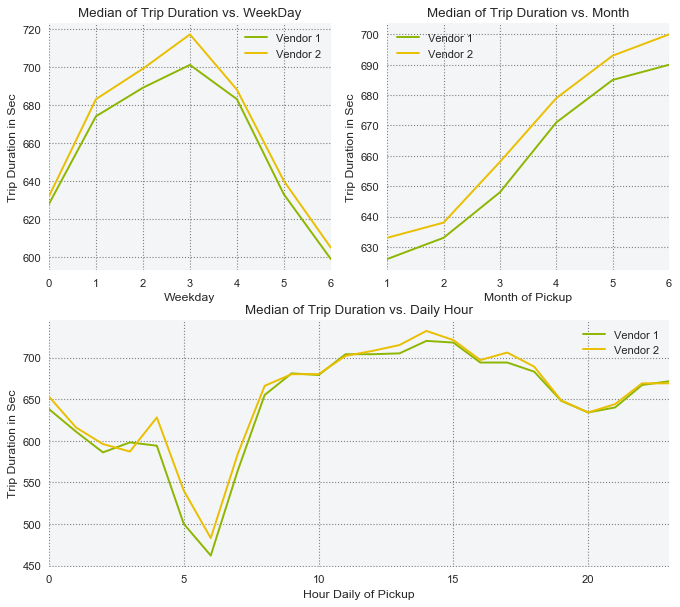

In [16]:
clr_key = ['#8DB600','#E9BF00']
df1 = train.groupby(['pickup_day_of_week','vendor_id'])['trip_duration'].median().reset_index()

plt.clf()
plt.figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0, :1])
ax2 = plt.subplot(gs[0, 1:2])
ax3 = plt.subplot(gs[1,:])

for key, grp in df1.groupby(['vendor_id']):
    ax1 = grp.plot(ax=ax1, kind='line', x='pickup_day_of_week', y='trip_duration', label='Vendor ' + str(key), c=clr_key[key-1])
ax1.legend(loc='best')
ax1.set_title('Median of Trip Duration vs. WeekDay')
ax1.set_xlabel('Weekday')
ax1.set_ylabel('Trip Duration in Sec')
ax1.grid(color='gray', linestyle=':', linewidth=1)

df2 = train.groupby(['pickup_month','vendor_id'])['trip_duration'].median().reset_index()
for key, grp in df2.groupby(['vendor_id']):
    ax2 = grp.plot(ax=ax2, kind='line', x='pickup_month', y='trip_duration', label='Vendor ' + str(key), c=clr_key[key-1])
ax2.legend(loc='best')
ax2.set_title('Median of Trip Duration vs. Month')
ax2.set_xlabel('Month of Pickup')
ax2.set_ylabel('Trip Duration in Sec')
ax2.grid(color='gray', linestyle=':', linewidth=1)

df3 = train.groupby(['pickup_hour','vendor_id'])['trip_duration'].median().reset_index()
for key, grp in df3.groupby(['vendor_id']):
    ax3 = grp.plot(ax=ax3, kind='line', x='pickup_hour', y='trip_duration', label='Vendor ' + str(key), c=clr_key[key-1])
ax3.legend(loc='best')
ax3.set_title('Median of Trip Duration vs. Daily Hour')
ax3.set_xlabel('Hour Daily of Pickup')
ax3.set_ylabel('Trip Duration in Sec')
ax3.grid(color='gray', linestyle=':', linewidth=1)


plt.show()
del(df1, df2, df3)

For the plot above, median is used to reduce influence of outlier which had been observed extensively. 

Vendor 2 typically has longer trip duration median when compared to vendor 1. The only deviations from this pattern is observed in 3am daily.

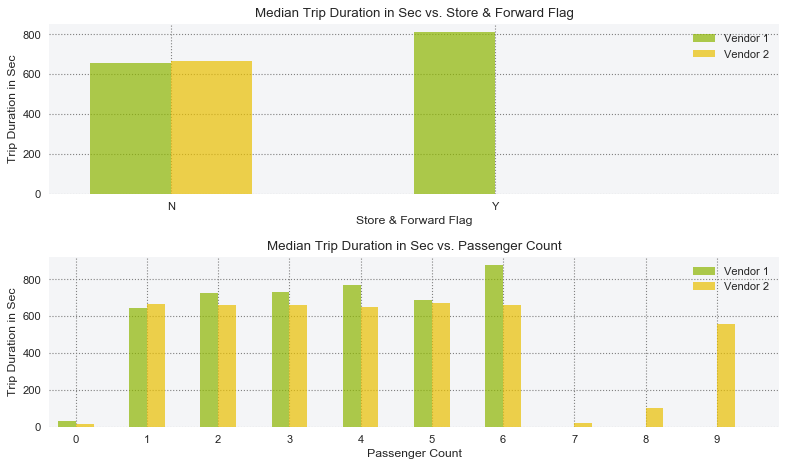

In [17]:
# Duration vs. Store flag
# Creating dataset for comparison of store & forward flag
fwd_flag_v1 = train[train['vendor_id']==1].groupby('store_and_fwd_flag')['trip_duration'].median().rename('v1').reset_index()
fwd_flag_v2 = train[train['vendor_id']==2].groupby('store_and_fwd_flag')['trip_duration'].median().rename('v2').reset_index()
fwd_flag_ls = fwd_flag_v1.merge(fwd_flag_v2, how='left', left_on='store_and_fwd_flag',right_on='store_and_fwd_flag')
fwd_flag_ls = fwd_flag_ls.fillna(0)

psg_count_v1 = train[train['vendor_id']==1].groupby('passenger_count')['trip_duration'].median().rename('v1').reset_index()
psg_count_v2 = train[train['vendor_id']==2].groupby('passenger_count')['trip_duration'].median().rename('v2').reset_index()
psg_count_ls = psg_count_v1.merge(psg_count_v2, how='outer', left_on='passenger_count',right_on='passenger_count')
psg_count_ls = psg_count_ls.fillna(0)
# Duration vs. Passenger count
width = 0.25


plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
# Number of pessanger
pos1 = list(range(len(fwd_flag_ls['store_and_fwd_flag'])))

#fig3, ax3 = plt.subplots(figsize=(10,5))
ax1.bar(pos1,fwd_flag_ls['v1'], width, color='#8DB600',alpha=0.7,label=fwd_flag_ls['store_and_fwd_flag'][0])
ax1.bar([p + width for p in pos1],fwd_flag_ls['v2'],  width,color='#E9BF00',alpha=0.7,label=fwd_flag_ls['store_and_fwd_flag'][0])
ax1.set_title("Median Trip Duration in Sec vs. Store & Forward Flag")
ax1.set_ylabel("Trip Duration in Sec")

# Set the position of the x ticks
ax1.set_xticks([p + 0.5 *width for p in pos1])

# Set the labels for the x ticks
ax1.set_xticklabels(fwd_flag_ls['store_and_fwd_flag'])
ax1.set_xlabel('Store & Forward Flag')

# Setting the x-axis and y-axis limits
ax1.set_xlim(min(pos1)-width, max(pos1)+width*4)
#ax3.set_ylim([0, max(psg_count_ls['train'] + psg_count_ls['test'])])
ax1.grid(color='grey', linestyle=':', linewidth=1)

# Number of pessanger
pos2 = list(range(len(psg_count_ls['passenger_count'])))

#fig3, ax3 = plt.subplots(figsize=(10,5))
ax2.bar(pos2,psg_count_ls['v1'], width,color='#8DB600', alpha=0.7,label=psg_count_ls['passenger_count'][0])
ax2.bar([p + width for p in pos2],psg_count_ls['v2'], width,alpha=0.7,color='#E9BF00',label=psg_count_ls['passenger_count'][0])
ax2.set_title("Median Trip Duration in Sec vs. Passenger Count")
ax2.set_ylabel("Trip Duration in Sec")

# Set the position of the x ticks
ax2.set_xticks([p + 0.5 *width for p in pos2])

# Set the labels for the x ticks
ax2.set_xticklabels(psg_count_ls['passenger_count'])
ax2.set_xlabel('Passenger Count')

# Setting the x-axis and y-axis limits
ax2.set_xlim(min(pos2)-width, max(pos2)+width*4)
#ax3.set_ylim([0, max(psg_count_ls['train'] + psg_count_ls['test'])])
ax2.grid(color='grey', linestyle=':', linewidth=1)

# Adding the legend and showing the plot
ax1.legend(['Vendor 1', 'Vendor 2'], loc='upper right')
ax2.legend(['Vendor 1', 'Vendor 2'], loc='upper right')
plt.tight_layout()
plt.show()

del(fwd_flag_v1, fwd_flag_v2 ,fwd_flag_ls,psg_count_v1,psg_count_v2,psg_count_ls)

## 3. Features Engineering
This section describes additional features generated from available and external dataset.

### 3.1 - Shortest Distance of Trip
The trip distance is estimated based on pickup and dropoff coordinate using haversine formula. As most of the trips are concentrated in Manhattan, the Manhattan Distance is also created.

In [18]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 3959  # in miles
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

# Define manhattan & harvesine distance
train.loc[:, 'haversine_dist'] = haversine_array(train['pickup_latitude'].values, \
                                                     train['pickup_longitude'].values, \
                                                     train['dropoff_latitude'].values, \
                                                     train['dropoff_longitude'].values)
train.loc[:, 'L1_distance'] = dummy_manhattan_distance(train['pickup_latitude'].values, \
                                                       train['pickup_longitude'].values, \
                                                       train['dropoff_latitude'].values, \
                                                       train['dropoff_longitude'].values)

test['haversine_dist'] = haversine_array(test['pickup_latitude'].values, \
                                                     test['pickup_longitude'].values, \
                                                     test['dropoff_latitude'].values, \
                                                     test['dropoff_longitude'].values)
test['L1_distance'] = dummy_manhattan_distance(test['pickup_latitude'].values, \
                                                       test['pickup_longitude'].values, \
                                                       test['dropoff_latitude'].values, \
                                                       test['dropoff_longitude'].values)

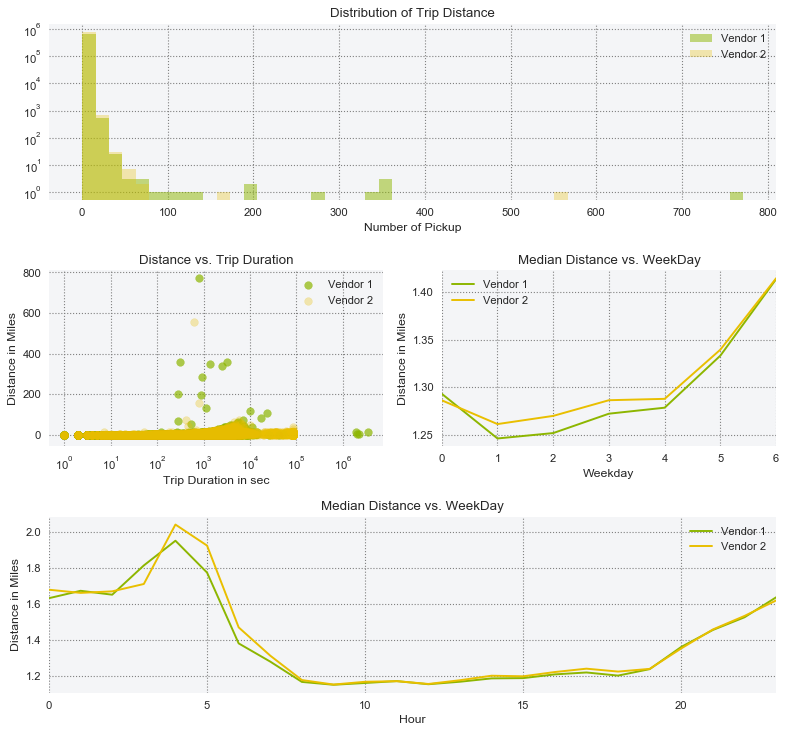

In [19]:
plt.clf()
plt.figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(4, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :1])
ax3 = plt.subplot(gs[1, 1:])
ax4 = plt.subplot(gs[2, :])

# Compare pickup w/ distance (hist)
min_trip_duration = train['haversine_dist'].min()
max_trip_duration = train['haversine_dist'].max()

bins = np.linspace(min_trip_duration, max_trip_duration, 50)
ax1.hist(train[train['vendor_id']==1]['haversine_dist'], alpha=0.5, bins=bins,color='#8DB600', label='Vendor 1')
ax1.hist(train[train['vendor_id']==2]['haversine_dist'], alpha=0.3, bins=bins,color='#E9BF00', label='Vendor 2')
#plt.hist(train['haversine_dist'], bins=100,color='#E9BF00', label='Vendor 2')
ax1.set_title('Distribution of Trip Distance')
ax1.set_xlabel('Trip Distance in mile')
ax1.set_ylabel('Number of Pickup')
ax1.legend(loc='upper right')
ax1.grid(color='gray', linestyle=':', linewidth=1)
ax1.set_yscale("log")

# Compare trip duration w/ distance (line plot - scatter w/ lmplot)
ax2.scatter(train[train['vendor_id']==1]['trip_duration'].values,\
            train[train['vendor_id']==1]['haversine_dist'].values, color='#8DB600', alpha=0.7, label='Vendor 1')
ax2.scatter(train[train['vendor_id']==2]['trip_duration'].values,\
            train[train['vendor_id']==2]['haversine_dist'].values, color='#E9BF00', alpha=0.3, label='Vendor 2')
ax2.set_title('Distance vs. Trip Duration')
ax2.set_xlabel('Trip Duration in sec')
ax2.set_ylabel('Distance in Miles')
ax2.legend(loc='best')
ax2.set_xscale('log')
ax2.grid(color='gray', linestyle=':', linewidth=1)

# Distance vs. Hr (line) - hue vendor
df1 = train.groupby(['pickup_day_of_week','vendor_id'])['haversine_dist'].median().reset_index()
for key, grp in df1.groupby(['vendor_id']):
    ax1 = grp.plot(ax=ax3, kind='line', x='pickup_day_of_week', y='haversine_dist', label='Vendor ' + str(key), c=clr_key[key-1])
ax3.legend(loc='best')
ax3.set_title('Median Distance vs. WeekDay')
ax3.set_xlabel('Weekday')
ax3.set_ylabel('Distance in Miles')
ax3.grid(color='gray', linestyle=':', linewidth=1)

df1 = train.groupby(['pickup_hour','vendor_id'])['haversine_dist'].median().reset_index()
for key, grp in df1.groupby(['vendor_id']):
    ax4 = grp.plot(ax=ax4, kind='line', x='pickup_hour', y='haversine_dist', label='Vendor ' + str(key), c=clr_key[key-1])
ax4.legend(loc='best')
ax4.set_title('Median Distance vs. WeekDay')
ax4.set_xlabel('Hour')
ax4.set_ylabel('Distance in Miles')
ax4.grid(color='gray', linestyle=':', linewidth=1)

plt.tight_layout()
plt.show()

del(df1)

Based on pickup, vendor 2 seems to have more long distance trip in comparison to vendor 1. In fact, all long distance trip except for 2 instances were performed by vendor 2. It's observed that median of distance travel is higher between 8pm to 5am - with peak at 4am pickup.


### 3.2 - Average Speed of Taxi
Since trip duration only available for training data, this features will not be used directly in making the prediction. The average speed is calculated using estimated distance/trip duration and the unit used would be in mile per hour.

In [20]:
train['avg_speed'] = train['haversine_dist'].values*3600/train['trip_duration'].values

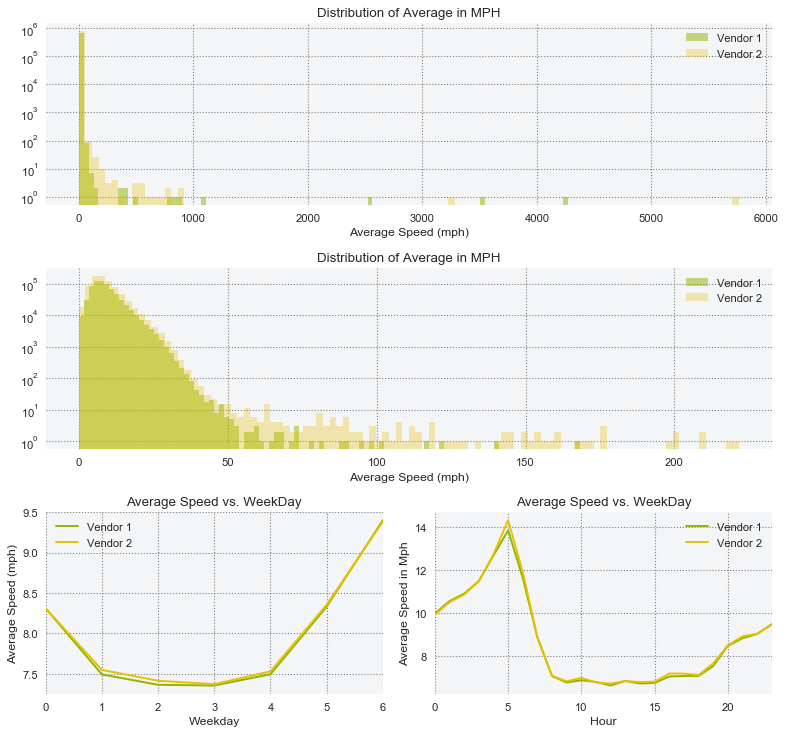

In [21]:
# Compare pickup w/ avg_speed (hist)
# avg_speed vs. Hr (lmplot)
# avg_speed vs. Day (bar)

plt.clf()
plt.figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(4, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :1])
ax4 = plt.subplot(gs[2, 1:])
#ax4 = plt.subplot(gs[2, :])

# Compare pickup w/ avg_speed (hist)
ax1.hist(train[train['vendor_id']==1]['avg_speed'], alpha=0.5, bins=100,color='#8DB600', label='Vendor 1')
ax1.hist(train[train['vendor_id']==2]['avg_speed'], alpha=0.3, bins=100,color='#E9BF00', label='Vendor 2')
ax1.set_title('Distribution of Average in MPH')
ax1.set_ylabel('Number of Pickup')
ax1.legend(loc='loc')
ax1.grid(color='gray', linestyle=':', linewidth=1)
ax1.set_yscale("log")
ax1.set_xlabel('Average Speed (mph)')

ax2.hist(train[(train['vendor_id']==1) & (train['avg_speed']<233)]['avg_speed'], alpha=0.5, bins=100,color='#8DB600', label='Vendor 1')
ax2.hist(train[(train['vendor_id']==2) & (train['avg_speed']<233)]['avg_speed'], alpha=0.3, bins=100,color='#E9BF00', label='Vendor 2')
ax2.set_title('Distribution of Average in MPH')
ax2.set_xlabel('Average Speed in MPH')
ax2.legend(loc='loc')
ax2.grid(color='gray', linestyle=':', linewidth=1)
ax2.set_yscale("log")
ax2.set_xlabel('Average Speed (mph)')

# Distance vs. Hr (line) - hue vendor
df1 = train.groupby(['pickup_day_of_week','vendor_id'])['avg_speed'].median().reset_index()
for key, grp in df1.groupby(['vendor_id']):
    ax3 = grp.plot(ax=ax3, kind='line', x='pickup_day_of_week', y='avg_speed', label='Vendor ' + str(key), c=clr_key[key-1])
ax3.legend(loc='best')
ax3.set_title('Average Speed vs. WeekDay')
ax3.set_xlabel('Weekday')
ax3.set_ylabel('Average Speed (mph)')
ax3.grid(color='gray', linestyle=':', linewidth=1)

df1 = train.groupby(['pickup_hour','vendor_id'])['avg_speed'].median().reset_index()
for key, grp in df1.groupby(['vendor_id']):
    ax4 = grp.plot(ax=ax4, kind='line', x='pickup_hour', y='avg_speed', label='Vendor ' + str(key), c=clr_key[key-1])
ax4.legend(loc='best')
ax4.set_xlabel('Hour')
ax4.set_ylabel('Average Speed in Mph')
ax4.grid(color='gray', linestyle=':', linewidth=1)


plt.tight_layout()
plt.show()

del(df1)

NYC definitely known for its gridlock, hence low average speed is expected. Although high performance NY Cab - beating F1 record speed of 233mph. Removing these 'supercab', the distribution of the pickup is left-skewed centred around 8mph. The average speed is consistently higher on weekend and off-peak hours.

### 3.3 Airport Pickup/Dropoff
In addition to normal pickup, features which determine whether the trip is a airport pickup/dropoff. As shown in the distribution of latitude and longitude of the pickup - all three airports (JFK, Newark & La Guardia) serving New York Metroplitan area would be used in determining this flag. The cutoff is based on 1miles radius around each airport area. 

In [22]:
airport_lat = [40.6413,40.6895, 40.7769]
airport_lng = [-73.7781,-74.1745, -73.8740]

label = []
for coord in range(0, len(airport_lat)):
    train['ap'+str(coord)] = haversine_array(train['pickup_latitude'].values,\
                train['pickup_longitude'].values,  airport_lat[coord], airport_lng[coord])
    train['ad'+str(coord)] = haversine_array(train['dropoff_latitude'].values,\
                train['dropoff_longitude'].values,  airport_lat[coord], airport_lng[coord])    
    label.append('ap'+str(coord))
    label.append('ad'+str(coord))
                 
train['closet_airport'] = train.loc[:, label].min(axis=1)
train['air_flag'] = train['closet_airport'] < 1

for coord in range(0, len(airport_lat)):
    test['ap'+str(coord)] = haversine_array(test['pickup_latitude'].values,\
                test['pickup_longitude'].values,  airport_lat[coord], airport_lng[coord])
    test['ad'+str(coord)] = haversine_array(test['dropoff_latitude'].values,\
                test['dropoff_longitude'].values,  airport_lat[coord], airport_lng[coord])    
    
test['closet_airport'] = test.loc[:, label].min(axis=1)
test['air_flag'] = test['closet_airport'] < 1

train = train.drop(label, axis=1)
test = test.drop(label, axis=1)

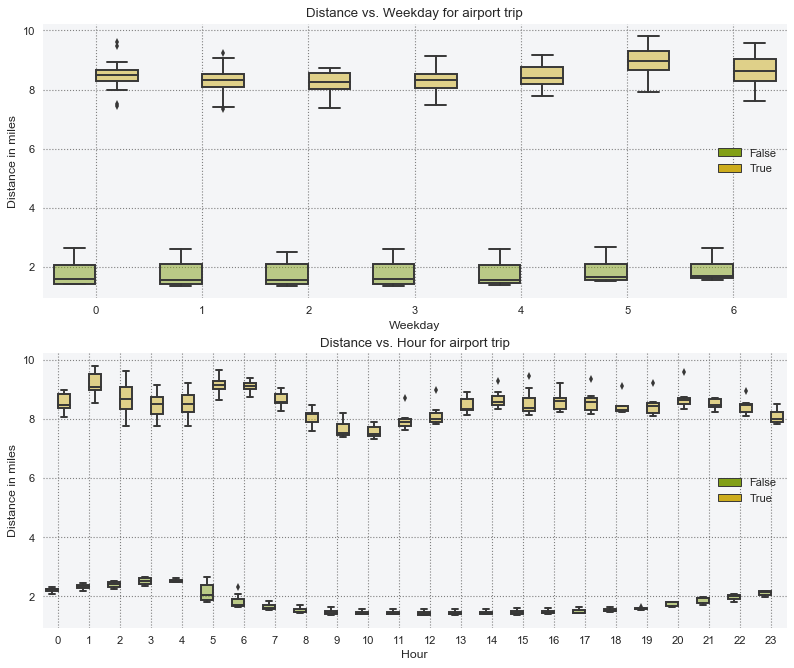

In [23]:
df = train.groupby(['pickup_day_of_week','pickup_hour','air_flag'])[['haversine_dist','avg_speed']].mean().reset_index()
NYC_cab = ["#8DB600", "#E9BF00"]

plt.clf()
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
_ = plt.subplot(2,1,1)
ax = sns.boxplot(x='pickup_day_of_week',y='haversine_dist',hue='air_flag',data=df, palette=sns.color_palette(NYC_cab))
plt.legend(loc='best')
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.title('Distance vs. Weekday for airport trip')
plt.ylabel('Distance in miles')
plt.xlabel('Weekday')

_ = plt.subplot(2,1,2)
ax = sns.boxplot(x='pickup_hour',y='haversine_dist',hue='air_flag',data=df, palette=sns.color_palette(NYC_cab))
plt.legend(loc='best')
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
plt.title('Distance vs. Hour for airport trip')
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.ylabel('Distance in miles')
plt.xlabel('Hour')

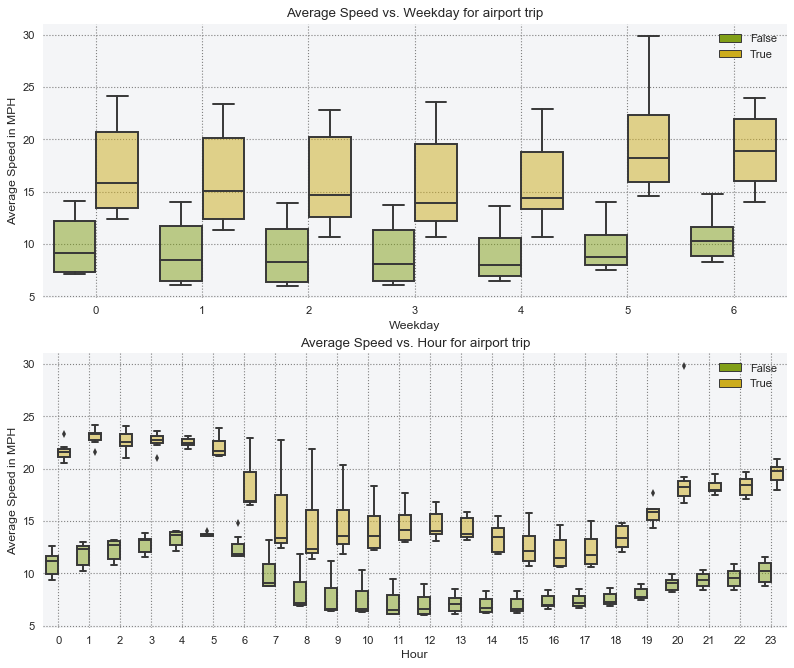

In [24]:
plt.clf()
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
_ = plt.subplot(2,1,1)
ax = sns.boxplot(x='pickup_day_of_week',y='avg_speed',hue='air_flag',data=df, palette=sns.color_palette(NYC_cab))
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
plt.legend(loc='best')
plt.title('Average Speed vs. Weekday for airport trip')
plt.ylabel('Average Speed in MPH')
plt.xlabel('Weekday')
plt.grid(color='grey', linestyle=':', linewidth=1)

_ = plt.subplot(2,1,2)
ax = sns.boxplot(x='pickup_hour',y='avg_speed',hue='air_flag',data=df, palette=sns.color_palette(NYC_cab))
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
plt.legend(loc='best')
plt.title('Average Speed vs. Hour for airport trip')
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.ylabel('Average Speed in MPH')
plt.xlabel('Hour')

del(df)

On average trip performeed from/to any of the three airports cover longer distance. The interesting fact is, average of its speed typically higher than non-airport trip. As typically airport are located away from Manhattan - the speed limit will be significantly higher than town area. 

### 3.4 Pickup/Drop-off Cluster
Moving on to geospatial data, instead of examining each individual pickup - kmean would be used to cluster pickup and dropoff coordinate. By grouping both training and test data together - we would be able to estimate pickup/dropoff speed for individual cluster. The clusters are also used to examine geospatial trip information.

In [25]:
# merge test and train data for clustering
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

centroids = kmeans.cluster_centers_
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
centroids = kmeans.cluster_centers_

#### Distribution of trip pickup & dropoff by location

In [26]:
import folium
NY_COORDINATES = [40.7128, -74.0059]

def set_leaf_color(colval, quantile_array):
    if colval > quantile_array[2]:
        return '#FF0000'
    elif colval > quantile_array[1]:
        return '#FFAA00'
    elif colval > quantile_array[0]:
        return '#BBFF00'
    else:
        return '#00FF00'


In [27]:
coord_pick = train.groupby('pickup_cluster').size().rename('pickup_no').reset_index()
coord_drop = train.groupby('dropoff_cluster').size().rename('dropoff_no').reset_index()
Z = pd.DataFrame(kmeans.cluster_centers_[coord_pick['pickup_cluster']], \
                columns=['centroid_x', 'centroid_y'])
locations = pd.concat([coord_pick,coord_drop, Z], axis=1) 
quantile_pick = locations['pickup_no'].quantile([.25,0.5,.75]).astype(int).tolist()
quantile_drop = locations['dropoff_no'].quantile([.25,0.5,.75]).astype(int).tolist()

m = folium.Map(location=NY_COORDINATES, zoom_start=12)

#Create a Folium feature group for this layer, since we will be displaying multiple layers
pickup_lyr = folium.FeatureGroup(name = 'pickup layer')
dropoff_lyr = folium.FeatureGroup(name = 'dropoff layer')

for lat,lon,cnt in zip(locations['centroid_x'],locations['centroid_y'],locations['pickup_no']):
    pickup_lyr.add_children(folium.CircleMarker(location=[lat,lon], radius=400,\
                                                color=set_leaf_color(cnt,quantile_pick), \
                                                fill_color=set_leaf_color(cnt,quantile_pick),\
                                                fill_opacity=0.7, popup= str(cnt)))
    
for lat,lon,cnt in zip(locations['centroid_x'],locations['centroid_y'],locations['dropoff_no']):
    dropoff_lyr.add_children(folium.RegularPolygonMarker(location=[lat,lon], radius=8, number_of_sides=8,\
                                                 fill_color=set_leaf_color(cnt,quantile_drop),\
                                                 popup= str(cnt)))
    
m.add_children(pickup_lyr)
m.add_children(dropoff_lyr)

folium.LayerControl().add_to(m)
m

Most of the trips are performed within Manhattan - with exception of higher pickup from JFK and La Guardia Airport. One of the cluster centred around Newark International Airport. In term of dropoff, again most trip started and ended within Manhattan.

In [28]:
m2 = folium.Map(location=NY_COORDINATES, zoom_start=12)

coord_pick = train.groupby('pickup_cluster')['avg_speed'].median().rename('pickup_speed').reset_index()
coord_drop = train.groupby('dropoff_cluster')['avg_speed'].median().rename('dropoff_speed').reset_index()
Z = pd.DataFrame(kmeans.cluster_centers_[coord_pick['pickup_cluster']], \
                columns=['centroid_x', 'centroid_y'])
locations = pd.concat([coord_pick,coord_drop, Z], axis=1) 
quantile_pick = locations['pickup_speed'].quantile([.25,0.5,.75]).astype(int).tolist()
quantile_drop = locations['dropoff_speed'].quantile([.25,0.5,.75]).astype(int).tolist()


#Create a Folium feature group for this layer, since we will be displaying multiple layers
pickup_lyr = folium.FeatureGroup(name = 'pickup layer')
dropoff_lyr = folium.FeatureGroup(name = 'dropoff layer')

for lat,lon,cnt in zip(locations['centroid_x'],locations['centroid_y'],locations['pickup_speed']):
    pickup_lyr.add_children(folium.CircleMarker(location=[lat,lon], radius=400,\
                                                color=set_leaf_color(cnt,quantile_pick), \
                                                fill_color=set_leaf_color(cnt,quantile_pick),\
                                                fill_opacity=0.7, popup= str(cnt)))
    
for lat,lon,cnt in zip(locations['centroid_x'],locations['centroid_y'],locations['dropoff_speed']):
    dropoff_lyr.add_children(folium.RegularPolygonMarker(location=[lat,lon], radius=8, number_of_sides=8,\
                                                 fill_color=set_leaf_color(cnt,quantile_drop),\
                                                 popup= str(cnt)))
    
m2.add_children(pickup_lyr)
m2.add_children(dropoff_lyr)

folium.LayerControl().add_to(m2)
m2

Based on pickup and dropoff location. we can see that the median of average speed is higher outside manhattan area. This again is expected due to the speed limit imposed within this area.

## 4. Data Cleaning
Records which will be removed can be categorised as follows

### 1. Short trips with less than 0.001 miles

In [29]:
df_walk = train[train['haversine_dist'] < 0.001]
train = train[train['haversine_dist'] > 0.001]

In [30]:
train[['haversine_dist','trip_duration','avg_speed']].sort_values(['avg_speed'], ascending=False).head(10)

,haversine_dist,trip_duration,avg_speed
id,,,
id3619353,11.206751,7,5763.471766
id1146400,359.698433,303,4273.644745
id2306955,771.112455,792,3505.056614
id1510552,553.808921,611,3263.031285
id0116374,198.929202,282,2539.521722
id3626673,282.891215,933,1091.541664
id1001696,349.378294,1405,895.204169
id1653963,0.486779,2,876.202787
id1935555,12.395971,51,875.009740


6946 records between 0 to 1/1000miles distance between pickup and dropoff were removed from the training dataset. Realistically it's possible to have such round trip - however it will not be possible to determine route taken by the taxi cab and would not be useful to the model.

### 2. Short trips with less than 10s durations

In [31]:
df_flash_trip = train[train['trip_duration'] <10 ]
print(len(df_flash_trip))
train = train[train['trip_duration'] >= 10]

990


In [32]:
train[['haversine_dist','trip_duration','avg_speed']].sort_values(['trip_duration'], ascending=False).head(10)

,haversine_dist,trip_duration,avg_speed
id,,,
id0053347,12.366460,3526282,0.012625
id1325766,1.016084,2227612,0.001642
id0369307,3.717574,2049578,0.006530
id1864733,12.520571,1939736,0.023237
id1942836,12.827585,86392,0.534532
id0593332,13.122369,86391,0.546822
id0953667,1.245258,86390,0.051892
id2837671,3.855163,86387,0.160656
id1358458,10.745696,86385,0.447815


rrrrr

### 3. Long Trip on NYC Cab
#### 3.1 Trip exceeding 1 day

In [33]:
df_day_trip = train[train['trip_duration'] > 86400]
df_day_trip[['haversine_dist','trip_duration','avg_speed']].sort_values(['trip_duration'], ascending=False).head(10)

,haversine_dist,trip_duration,avg_speed
id,,,
id0053347,12.366460,3526282,0.012625
id1325766,1.016084,2227612,0.001642
id0369307,3.717574,2049578,0.006530
id1864733,12.520571,1939736,0.023237


In [34]:
m4 = folium.Map(location=NY_COORDINATES, zoom_start=10)

for plat, plon, dlat, dlon  in zip(df_day_trip['pickup_latitude'],df_day_trip['pickup_longitude'],\
                                        df_day_trip['dropoff_latitude'],df_day_trip['dropoff_longitude']):
    m4.polygon_marker(location=[dlat,dlon],line_color='green',\
                     fill_color='green', num_sides=6, radius=5, fill_opacity=0.9)                      
    folium.PolyLine([(dlat,dlon),(plat,plon)], color="green", weight=1.5, opacity=0.9).add_to(m4)
    
m4

In [35]:
train = train[train['trip_duration'] <= 86400]

The four daytrips occured inside NYC and despite of the traffic congestion within the city - it is highly impossible for the trip to exceed one day. These data are removed from the train dataset.

#### 3.2 Trip exceeding 5hr (2nd peak in trip time distribution)
Taxi drivers are currently limited to shifts of 12 hours, which are common in the industry. A break of any length, resets that clock. Hence, trip duration should not exceed 12hrs.

In [36]:
df_overwork = train[train['trip_duration'] > 43200]
df_overwork[['haversine_dist','trip_duration','avg_speed']].sort_values(['haversine_dist'], ascending=False).head(5)


,haversine_dist,trip_duration,avg_speed
id,,,
id1858895,37.656289,85561,1.584398
id1561128,26.318974,85828,1.103932
id3695440,19.802113,58583,1.216865
id0704938,17.451959,85102,0.738256
id0662183,15.280103,65550,0.839182


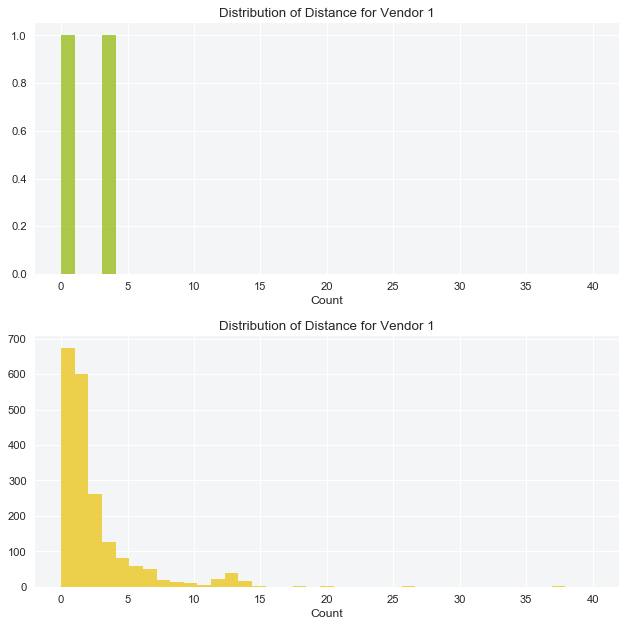

In [37]:
bins = np.linspace(0,40,40)

plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(211)
plt.hist(df_overwork[df_overwork['vendor_id']==1]['haversine_dist'], bins=bins, alpha=0.7,color='#8DB600', label='Vendor 1')
plt.title('Distribution of Distance for Vendor 1')
plt.xlabel('Distance in miles')
plt.xlabel('Count')

ax2 = plt.subplot(212, sharex=ax)
plt.subplot(2,1,2)
plt.hist(df_overwork[df_overwork['vendor_id']==2]['haversine_dist'], bins=bins, alpha=0.7,color='#E9BF00', label='Vendor 1')
plt.title('Distribution of Distance for Vendor 1')
plt.xlabel('Distance in miles')
plt.xlabel('Count')

plt.tight_layout()
plt.show()



Most of the trip exceeding 12hrs occurs within NYC boundaries and travelled between 0 to 2 miles. Although this seems to be erroneous, we had observed above - that none of vendor 2 has store_and_fwd_flag is true. Hence these data will not be removed from the training dataset.

### 4. Need for Speed - New York City Edition
New York City speed limit varies between 25-65mph, however training dataset is showing upto 4000mph. Arbitrarily, the limit of 2x is used to remove these data

In [38]:
df_speedster = train[train['avg_speed'] > 130]
len(df_speedster)
#df_speedster[['haversine_dist','trip_duration','avg_speed']].sort_values(['avg_speed'], ascending=True)

34

In [39]:
m6 = folium.Map(location=NY_COORDINATES, zoom_start=8)

for plat, plon, dlat, dlon  in zip(df_speedster['pickup_latitude'],df_speedster['pickup_longitude'],\
                                        df_speedster['dropoff_latitude'],df_speedster['dropoff_longitude']):
    m6.polygon_marker(location=[dlat,dlon],line_color='green',\
                     fill_color='green', num_sides=6, radius=5, fill_opacity=0.9)
    m6.polygon_marker(location=[plat,plon],line_color='red',\
                     fill_color='red', num_sides=6, radius=5, fill_opacity=0.9) 
    folium.PolyLine([(dlat,dlon),(plat,plon)], color="green", weight=1.5, opacity=0.9).add_to(m6)
    
m6

In [40]:
train = train[train['avg_speed'] <= 130]

34 recordset were removed from the training data. 

### 5. Pickup/Dropoff Point (Out of state/invalid)

In [41]:
import math
NYState_latitude = [40.49444, 45.01167]
NYState_longitude = [-71.79028, -79.765]

NYC_lat = [40.92, 40.50]
NYC_lng = [-74.26, -73.70]


outstate_pickup = train[(train['pickup_longitude']<-79.77) | (train['pickup_longitude']>--71.79) | \
(train['pickup_latitude']< 40.49) | (train['pickup_latitude']>45.01)]\
[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]

outstate_dropoff = train[(train['dropoff_longitude']<-79.77) | (train['dropoff_longitude']>-71.79) | \
(train['dropoff_latitude']< 40.49) | (train['dropoff_latitude']>45.01)]\
[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]

outstate_trip = pd.concat([outstate_pickup,outstate_dropoff]).drop_duplicates()
outstate_trip.reset_index()

,id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,id0367149,40.449749,-74.079620,40.444698,-74.062263
1,id2255271,40.433842,-74.069733,40.441662,-74.082153
2,id1311087,39.803932,-75.455917,40.707726,-73.796021
3,id1162751,40.225803,-74.075287,40.225800,-74.075172
4,id1763411,40.439362,-74.065468,40.461922,-74.072647
5,id0513650,40.413231,-74.084999,40.452099,-74.080452
6,id0051303,40.436295,-74.521576,40.436321,-74.521576
7,id2797971,40.452400,-74.053719,40.416168,-74.086731
8,id0083561,40.355713,-74.612442,40.355610,-74.612503
9,id1125911,35.310307,-72.074333,35.173546,-72.022408


In [42]:
m = folium.Map(location=[40, -102], zoom_start=4)

for plat, plon, dlat, dlon, tripid  in zip(outstate_trip['pickup_latitude'],outstate_trip['pickup_longitude'],\
                                        outstate_trip['dropoff_latitude'],outstate_trip['dropoff_longitude'],\
                                   outstate_trip.index.values):
    m.polygon_marker(location=[dlat,dlon],line_color='green',\
                     fill_color='green', num_sides=6, radius=5, fill_opacity=0.9, popup= tripid)                      
    folium.PolyLine([(dlat,dlon),(plat,plon)], color="green", weight=1.5, opacity=0.9).add_to(m)
    
m

Above map displayed all trips which has either pickup and/or dropoff coordinate outside NYC boundaries. Two coordinates that immediately stood out are the trip which occured in Atlantic ocean and San Jose. This will be removed from the training dataset. 

In [43]:
outstate_trip.sort_values('pickup_latitude')
train = train[train['pickup_latitude']>38]

Lastly will try to remove trip with pickup/dropoff in body of water